# Project 2: Caitlin Streamer 

## Kaggle Challenge: Ames, IA Housing Analysis and Prediction 

### Personal Website: https://caitlinstreamer.wordpress.com/portfolio/modeling-home-prices-in-ames-ia/

In [1]:
# Bring in libraries, and set some variables for the whole notebook 
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso, ElasticNet, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import sklearn.metrics as metrics

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Step 1: Load and Read Data 

In [2]:
# Load the train data 
ames = pd.read_csv('train.csv')
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# Load the test data 
test = pd.read_csv('test.csv')

In [4]:
# Gain familiarity with the train data, identify dtype, number of rows, non-nulls values, etc. 
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

In [5]:
# Identify columns with more than 1000 NaN values -- are potential candiates to drop since 50% of data is missing 
result = []
for column in ames.columns:
    if ames[column].isna().sum() >= 1000:
        result.append(column)
result

['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']

After reading through the provided column descriptions, NaN in Alley means no alley access, NaN in Fireplace Qu means no fireplace, NaN in Pool QC means no pool, NaN in fence means no Fence, NaN in Misc Feature means no misc feature. Considering that these NaN values actually mean something and are not missing data, I am going to replace the NaNs with string objects that will later be taken into account with dummy variables so that these features can be candidates to include in the model. There are also other categorical columns where NaN actually mean No. I will update these as well. 

### Step 2. Clean the data

In [6]:
# Investigate all columns containing NaNs in train data 
nan_dict = dict(ames.isna().sum())
{key:value for key,value in nan_dict.items() if value != 0}

{'Alley': 1911,
 'Bsmt Cond': 55,
 'Bsmt Exposure': 58,
 'Bsmt Full Bath': 2,
 'Bsmt Half Bath': 2,
 'Bsmt Qual': 55,
 'Bsmt Unf SF': 1,
 'BsmtFin SF 1': 1,
 'BsmtFin SF 2': 1,
 'BsmtFin Type 1': 55,
 'BsmtFin Type 2': 56,
 'Fence': 1651,
 'Fireplace Qu': 1000,
 'Garage Area': 1,
 'Garage Cars': 1,
 'Garage Cond': 114,
 'Garage Finish': 114,
 'Garage Qual': 114,
 'Garage Type': 113,
 'Garage Yr Blt': 114,
 'Lot Frontage': 330,
 'Mas Vnr Area': 22,
 'Mas Vnr Type': 22,
 'Misc Feature': 1986,
 'Pool QC': 2042,
 'Total Bsmt SF': 1}

In [7]:
# Replace NaNs in 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature' columns with "No" string 
nan_columns = ['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
ames[nan_columns] = ames[nan_columns].fillna("No")

# Make same changes to test data
test[nan_columns] = test[nan_columns].fillna("No")

I will also replace NaNs in BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, and GarageCond since they also refer to No and have a meaning according to the column descriptions 

In [8]:
# Update rest of meaningful NaNs in the dataframe 
na_columns = ['Bsmt Qual','Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
              'BsmtFin Type 2','Garage Type','Garage Finish','Garage Qual','Garage Cond']
ames[na_columns] = ames[na_columns].fillna("No")

# Make same changes to test data 
test[na_columns] = test[na_columns].fillna("No")

Lot Frontage has 330 NaNs in the train data. After reading the column description, this column represents square footage of frontage area. I am going to assume that NaN refers to 0, as in the house doesn't have a front yard, which makes sense since the min value is 21, meaning the data doesn't represent homes with no front yards. 

In [9]:
# Update NaNs in Lot Frontage to 0 
ames['Lot Frontage'] = ames['Lot Frontage'].fillna(0)

# Make changes to test data
test['Lot Frontage'] = test['Lot Frontage'].fillna(0)

Garage Yr Blt is a problematic feature. While these years are ordinal, if a house doesn't have a garage, it doesn't make sense to make its value 0. I could create another dummy column for "Has Garage?" and then create an interaction feature for ("Has Garage?" * "Garage Yr Blt") which the model could then account for their interaction. However, when thinking about the goal of predicting home prices, I'm not sure that this adds any new information except to say, is this garage new? Considering these issues, I have decided to drop this column and not include it in my model. 

In [10]:
# Drop Garage Yr Blt from both the train and test data
ames.drop('Garage Yr Blt', axis = 1, inplace = True)
test.drop('Garage Yr Blt', axis = 1, inplace = True) 

After investigating Mas Vnr Area and Type, there is no way to infer what the NaN values may mean based on the other columns. Since there are only 22 rows with NaN values, I will drop these rows in the train data. 

In [11]:
# Drop NaN Mas Vnr Area rows from train data - this will also drop the missing Type ones since they are the same rows
ames.drop(ames.loc[pd.isna(ames['Mas Vnr Type'])].index, inplace = True)

Investigate train data for remaining NaNs 

In [12]:
# Create dictionary of column names, number of NaNs in the train data
nan_dict = dict(ames.isna().sum())
{key:value for key,value in nan_dict.items() if value != 0}

{'Bsmt Full Bath': 2,
 'Bsmt Half Bath': 2,
 'Bsmt Unf SF': 1,
 'BsmtFin SF 1': 1,
 'BsmtFin SF 2': 1,
 'Garage Area': 1,
 'Garage Cars': 1,
 'Total Bsmt SF': 1}

In [13]:
# Identify row numbers for remaining NaN values -- 1327, 616, and 1712
remaining_nan = ['Bsmt Full Bath','Bsmt Half Bath','Bsmt Unf SF','BsmtFin SF 1',
                 'BsmtFin SF 2','Garage Area','Garage Cars','Total Bsmt SF']
results = []
for column in remaining_nan:
    nan = ames[ames[column].isna() == True]
    results.append(nan.index)
results

[Int64Index([616, 1327], dtype='int64'),
 Int64Index([616, 1327], dtype='int64'),
 Int64Index([1327], dtype='int64'),
 Int64Index([1327], dtype='int64'),
 Int64Index([1327], dtype='int64'),
 Int64Index([1712], dtype='int64'),
 Int64Index([1712], dtype='int64'),
 Int64Index([1327], dtype='int64')]

In [14]:
# Update train row 1327, 616 basement NaNs to 0 since they don't have basement per the other columns 
ames['Bsmt Half Bath'].fillna(0,inplace=True)
ames['Bsmt Full Bath'].fillna(0, inplace = True)

In [15]:
# Update train row 1327 basement NaNs to 0 since it doesn't have a basement per the other columns 
ames['Bsmt Unf SF'].fillna(0,inplace=True)
ames['BsmtFin SF 1'].fillna(0, inplace = True)
ames['BsmtFin SF 2'].fillna(0,inplace=True)
ames['Total Bsmt SF'].fillna(0, inplace = True)

In [16]:
# Will drop train row 1712 since it has conflicting information about garage. The row has a detatched garage type but 
# then no garage per the defined NaN definitions for the other garage columns 
ames.drop(1712, inplace = True)

In [17]:
# Confirm that all NaNs are gone from the train data 
ames.isna().sum().sum()

0

Investigate test data for remaining NaNs. It is also important to note that I can't drop any rows from the test data so I will have to make some assumptions should I not be able to infer NaN values from the column descriptions or the other columns

In [18]:
# Create dictionary of column names, number of NaNs in the test data
nan_dict2 = dict(test.isna().sum())
{key:value for key,value in nan_dict2.items() if value != 0}

{'Electrical': 1, 'Mas Vnr Area': 1, 'Mas Vnr Type': 1}

In [19]:
# Will update Electrical value to the most frequent electrical system in the training data, SBrkr 
ames['Electrical'].value_counts()

SBrkr    1845
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: Electrical, dtype: int64

In [20]:
# Update test data with SBrKr in electrical NaN row 
test['Electrical'].fillna("SBrkr",inplace=True)

In [21]:
# Will update Mas Vnr Area value to the most frequent value in the training data, 0
ames['Mas Vnr Area'].value_counts().head()

0.0      1215
120.0      11
176.0      10
200.0      10
180.0       9
Name: Mas Vnr Area, dtype: int64

In [22]:
# Will update Mas Vnr Type value to the most frequent value in the training data, None
ames['Mas Vnr Type'].value_counts().head()

None       1217
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [23]:
# Update test data with assumptions: 0 for Mas Vnr Area and Mas Vnr Type as None 
test['Mas Vnr Area'].fillna(0,inplace=True)
test['Mas Vnr Type'].fillna("None",inplace=True)

In [24]:
# Confirm test data has no NaNs
test.isna().sum().sum()

0

While I was reading through column descriptions, I also came across a numerical column that was not ordinal, MSSubclass. The numbers were actually codes for descriptions. Since these are not meaningful numbers I will replace them with the provided descriptions. 

In [25]:
# MSSubclass is not an ordinal numeric -- will covert to categorical using a dictionary 
mssubclass_dict = {20: "1-STORY 1946 & NEWER ALL STYLES",
                30: "1-STORY 1945 & OLDER",
                40: "1-STORY W/FINISHED ATTIC ALL AGES",
                45: "1-1/2 STORY - UNFINISHED ALL AGES",
                50: "1-1/2 STORY FINISHED ALL AGES",
                60: "2-STORY 1946 & NEWER",
                70: "2-STORY 1945 & OLDER",
                75: "2-1/2 STORY ALL AGES",
                80: "SPLIT OR MULTI-LEVEL",
                85: "SPLIT FOYER",
                90: "DUPLEX - ALL STYLES AND AGES",
                120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
                150: "1-1/2 STORY PUD - ALL AGES",
                160: "2-STORY PUD - 1946 & NEWER",
                180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
                190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"}

# Update MS SubClass using dictionary above in both train and test datasets 
ames["MS SubClass"] = ames["MS SubClass"].map(mssubclass_dict)
test['MS SubClass'] = test['MS SubClass'].map(mssubclass_dict)

We also need to covert all year and month sold values into categorical factors since these numerics are not really ordinal. These include Year Built, Year Remod/Add, Garage Year Blt, Mo Sold, and Yr Sold.   

In [26]:
# Change Mo Sold into categorical 
month_dict = {1: "Jan", 
              2: "Feb",
              3: "Mar",
              4: "Apr",
              5: "May",
              6: "Jun",
              7: "Jul",
              8: "Aug",
              9: "Sep",
              10: "Oct",
              11: "Nov",
              12: "Dec"}

#Update Mo Sold using dictionary above in both train and test datasets
ames["Mo Sold"] = ames["Mo Sold"].map(month_dict)
test['Mo Sold'] = test['Mo Sold'].map(month_dict)

There are a handful of columns that are categorical but are really ordinal. Lot Shape, Land Slope, Exter Qual, Exter Cond, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type 2, Heating QC, Kitchen Qual, Functional, Fireplace Qu, Garage Finish, Garage Qual, Garage Cond, and Pool QC will all be converted on a point scale to represent their ordinal relationships. This will also reduce the final number of columns for the model, since these columns will not need to be dummied. 

In [27]:
# Define ordinal relatioships for the columns mentioned above 
lot_dict = {'Reg': 4, 'IR1': 3,'IR2': 2, "IR3": 1}
land_dict = {'Gtl':3, 'Mod': 2, 'Sev': 1}
exqual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 }
excond_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 }
bsmtq_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 , 'No': 0}
bsmtc_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 , 'No': 0}
bsmtex_dict = {'Gd': 4, 'Av':3, 'Mn':2, 'No':1}
bsmtfin1_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'No':0}
bsmtfin2_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'No':0}
heat_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 }
kit_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 }
fun_dict = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod':5, 'Maj1':4, 'Maj2': 3, 'Sev': 2, 'Sal':1}
fire_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 , 'No': 0}
garf_dict = {'Fin':3, 'RFn':2, 'Unf':1, 'No':0}
garq_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 , 'No': 0}
garc_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1 , 'No': 0}
pool_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'No': 0}  

In [28]:
#Update columns  using dictionaries above in both train and test datasets
all_dicts = {'Lot Shape': lot_dict, 'Land Slope':land_dict, 'Exter Qual':exqual_dict, 'Exter Cond':excond_dict,
             'Bsmt Qual':bsmtq_dict, 'Bsmt Cond':bsmtc_dict, 'Bsmt Exposure': bsmtex_dict,
             'BsmtFin Type 1': bsmtfin1_dict, 'BsmtFin Type 2': bsmtfin2_dict, 'Heating QC': heat_dict, 
             'Kitchen Qual': kit_dict, 'Functional': fun_dict, 'Fireplace Qu': fire_dict,
             'Garage Finish': garf_dict, 'Garage Qual':garq_dict, 'Garage Cond':garc_dict,'Pool QC': pool_dict}

for col, col_dict in all_dicts.items():
    ames[col] = ames[col].map(col_dict)
    test[col] = test[col].map(col_dict)

### Step 3: Feature Engineering 

In [29]:
# Before I change Yr Sold into a categorical value, I want to create an Age column 
# Age = Yr Sold - Year Remod/Add  (I am assuming that remodel is a complete home remodel)
ames['Age'] = ames['Yr Sold'] - ames['Year Remod/Add']
test['Age'] = test['Yr Sold'] - test['Year Remod/Add']

In [30]:
# Create an IsNew column: IsNew when Yr Sold = Year Built
ames['IsNew'] = (ames['Yr Sold'] == ames['Year Built']).astype('int')
test['IsNew'] = (test['Yr Sold'] == test['Year Built']).astype('int')

In [31]:
# Create an IsRemodeled column, which when taken with Age can replace the Year Remod/Add column 
# IsRemodeled is true when Yr Built = Year Remod/Add 
ames['IsRemodeled'] = (ames['Year Built'] == ames['Year Remod/Add']).astype('int')
test['IsRemodeled'] = (test['Year Built'] == test['Year Remod/Add']).astype('int')

In [32]:
# Drop Year Built and Year Remod/Add
ames.drop(['Year Built', 'Year Remod/Add'], axis = 1, inplace = True)
test.drop(['Year Built', 'Year Remod/Add'], axis = 1, inplace = True)

In [33]:
# Convert Yr Sold into categorical values since we are only looking at 2006 - 2010
ames['Yr Sold'] = ames['Yr Sold'].astype(dtype = "object")
test['Yr Sold'] = test['Yr Sold'].astype(dtype = "object")

In [34]:
# Create a total bathroom column to replace the other bathroom columns (Half Bath, Full Bath, Bsmt Half and Full Bath)
# A half bathroom is represented as 0.5 full bathrooms 
ames['Total Bath'] = 0.5*ames['Half Bath'] + ames['Full Bath'] + 0.5*ames['Bsmt Half Bath'] + ames['Bsmt Full Bath']
test['Total Bath'] = 0.5*test['Half Bath'] + test['Full Bath'] + 0.5*test['Bsmt Half Bath'] + test['Bsmt Full Bath']

In [35]:
# Drop the 4 original bathroom columns 
ames.drop(['Half Bath', 'Full Bath', 'Bsmt Half Bath', 'Bsmt Full Bath'], axis = 1, inplace = True)
test.drop(['Half Bath', 'Full Bath', 'Bsmt Half Bath', 'Bsmt Full Bath'], axis = 1, inplace = True)

In [36]:
# Total square footage of the house: total =  total bsmt sf + 1st flr sf + 2nd flr sf
ames['Total SF'] = ames['Total Bsmt SF'] + ames['1st Flr SF'] + ames['2nd Flr SF']
test['Total SF'] = test['Total Bsmt SF'] + test['1st Flr SF'] + test['2nd Flr SF']

In [37]:
# Drop the original square footage columns 
ames.drop(['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], axis = 1, inplace = True)
test.drop(['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], axis = 1, inplace = True)

In [38]:
# Create a total porch SF column: total = Wood Deck SF + Open Porch SF + Enclosed Porch + 3Ssn Porch + Screen Porch
ames['Total Porch SF'] = ames['Wood Deck SF'] + ames['Open Porch SF'] + ames['Enclosed Porch'] + ames['3Ssn Porch'] + ames['Screen Porch']
test['Total Porch SF'] = test['Wood Deck SF'] + test['Open Porch SF'] + test['Enclosed Porch'] + test['3Ssn Porch'] + test['Screen Porch']

In [39]:
# Drop original 5 porch columns 
ames.drop(['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch'], axis = 1, inplace = True)
test.drop(['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch'], axis = 1, inplace = True)

In [40]:
# Create Has Garage column 
ames['Has Garage'] = (ames['Garage Type'] != 'No').astype('int')
test['Has Garage'] = (test['Garage Type'] != 'No').astype('int')

In [41]:
# Drop original Garage columns 
ames.drop(['Garage Type', 'Garage Finish', 'Garage Area', 'Garage Qual', 'Garage Cars','Garage Cond'], axis = 1, inplace = True)
test.drop(['Garage Type', 'Garage Finish', 'Garage Area', 'Garage Qual', 'Garage Cars','Garage Cond'], axis = 1, inplace = True)

### Step 4: EDA

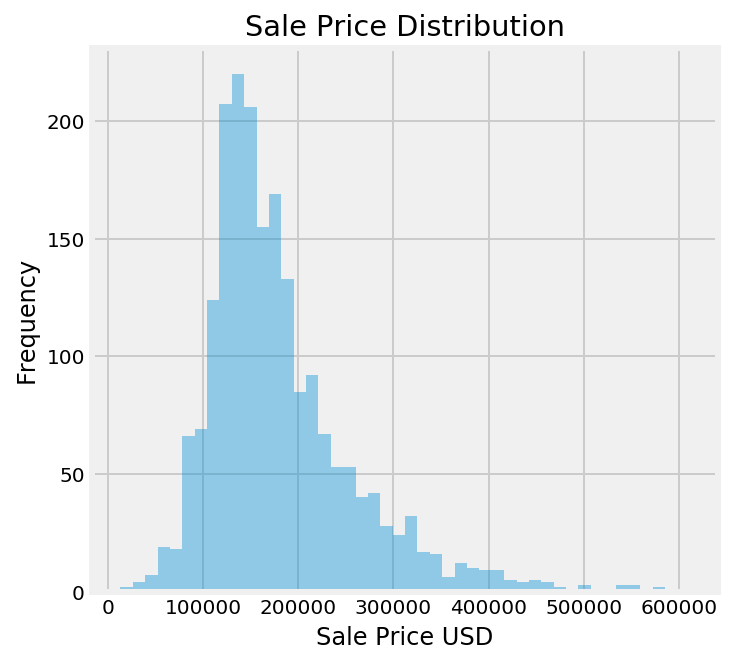

In [42]:
# SalePrice Histogram - SalePrice is skewed right, which makes sense since few people can afford expensive homes
fig = plt.figure(figsize = (5,5))
sns.distplot(ames['SalePrice'], kde = False)
plt.xlabel('Sale Price USD')
plt.ylabel('Frequency')
plt.title('Sale Price Distribution');

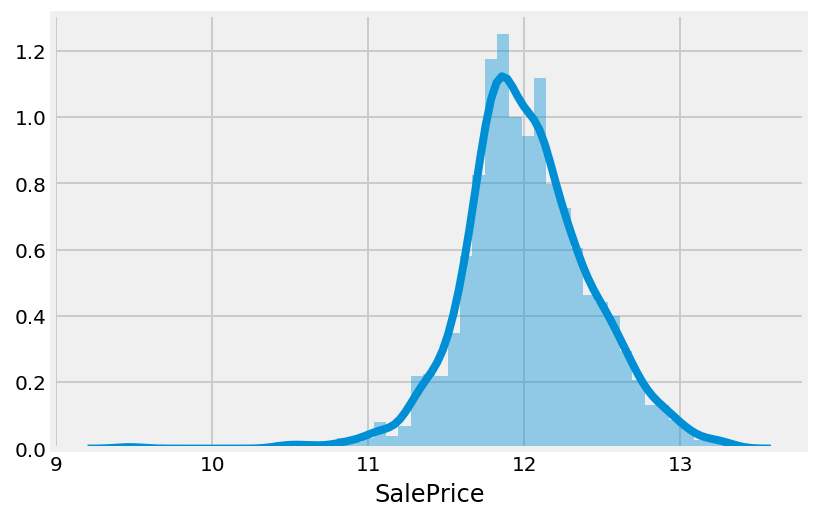

In [43]:
# Histogram of the log of SalePrice - distribution is more normal 
# I will have to account for this skewness later in modeling, as well as for other skewed predictors
sns.distplot(np.log(ames['SalePrice']));

In [44]:
# Investigate numeric variable correlations for further investigation 
ames.corr()

,Id,PID,Lot Frontage,Lot Area,Lot Shape,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,...,Pool QC,Misc Val,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
Id,1.000000,0.174565,-0.016569,0.030871,-0.009233,-0.014516,-0.063925,-0.025000,-0.035249,-0.072642,...,0.048730,-0.012614,-0.054908,0.030808,0.084605,0.018128,-0.074181,-0.039381,0.002969,-0.031586
PID,0.174565,1.000000,-0.039402,0.023397,0.092761,-0.115987,-0.262106,0.105513,-0.247754,-0.220343,...,0.024968,0.003695,-0.252114,0.172081,-0.120071,-0.229119,-0.190844,-0.188769,-0.030170,-0.136223
Lot Frontage,-0.016569,-0.039402,1.000000,0.138448,0.174134,0.009189,0.113466,-0.034953,0.101943,0.101748,...,0.100779,0.026155,0.179640,-0.058191,0.113804,-0.053372,0.034074,0.220081,0.065972,0.002039
Lot Area,0.030871,0.023397,0.138448,1.000000,-0.302788,-0.305223,0.106155,-0.015331,0.169352,0.087744,...,0.128543,0.094423,0.297307,-0.053738,0.034707,-0.026233,0.175643,0.354482,0.216428,0.085676
Lot Shape,-0.009233,0.092761,0.174134,-0.302788,1.000000,0.108178,-0.249178,0.075111,-0.130203,-0.237865,...,-0.055591,-0.050342,-0.295577,0.223938,-0.012857,-0.070027,-0.241898,-0.262868,-0.152324,-0.111048
Land Slope,-0.014516,-0.115987,0.009189,-0.305223,0.108178,1.000000,0.033484,0.000730,-0.026915,0.028021,...,0.013483,0.005502,-0.059970,-0.050036,0.031864,0.039819,-0.014403,-0.027028,-0.088833,-0.008480
Overall Qual,-0.063925,-0.262106,0.113466,0.106155,-0.249178,0.033484,1.000000,-0.079002,0.438568,0.738252,...,0.023416,0.023036,0.799201,-0.583393,0.235678,0.092099,0.541787,0.659785,0.301600,0.247168
Overall Cond,-0.025000,0.105513,-0.034953,-0.015331,0.075111,0.000730,-0.079002,1.000000,-0.135785,-0.151775,...,-0.008950,0.013787,-0.094061,-0.044296,-0.091162,-0.271409,-0.184139,-0.153668,0.049193,0.034454
Mas Vnr Area,-0.035249,-0.247754,0.101943,0.169352,-0.130203,-0.026915,0.438568,-0.135785,1.000000,0.376325,...,0.014723,0.079200,0.512182,-0.213058,0.092659,0.108694,0.320671,0.470710,0.192524,0.114179
Exter Qual,-0.072642,-0.220343,0.101748,0.087744,-0.237865,0.028021,0.738252,-0.151775,0.376325,1.000000,...,0.034671,0.014055,0.711050,-0.614302,0.271579,0.069584,0.471735,0.535751,0.239007,0.183114


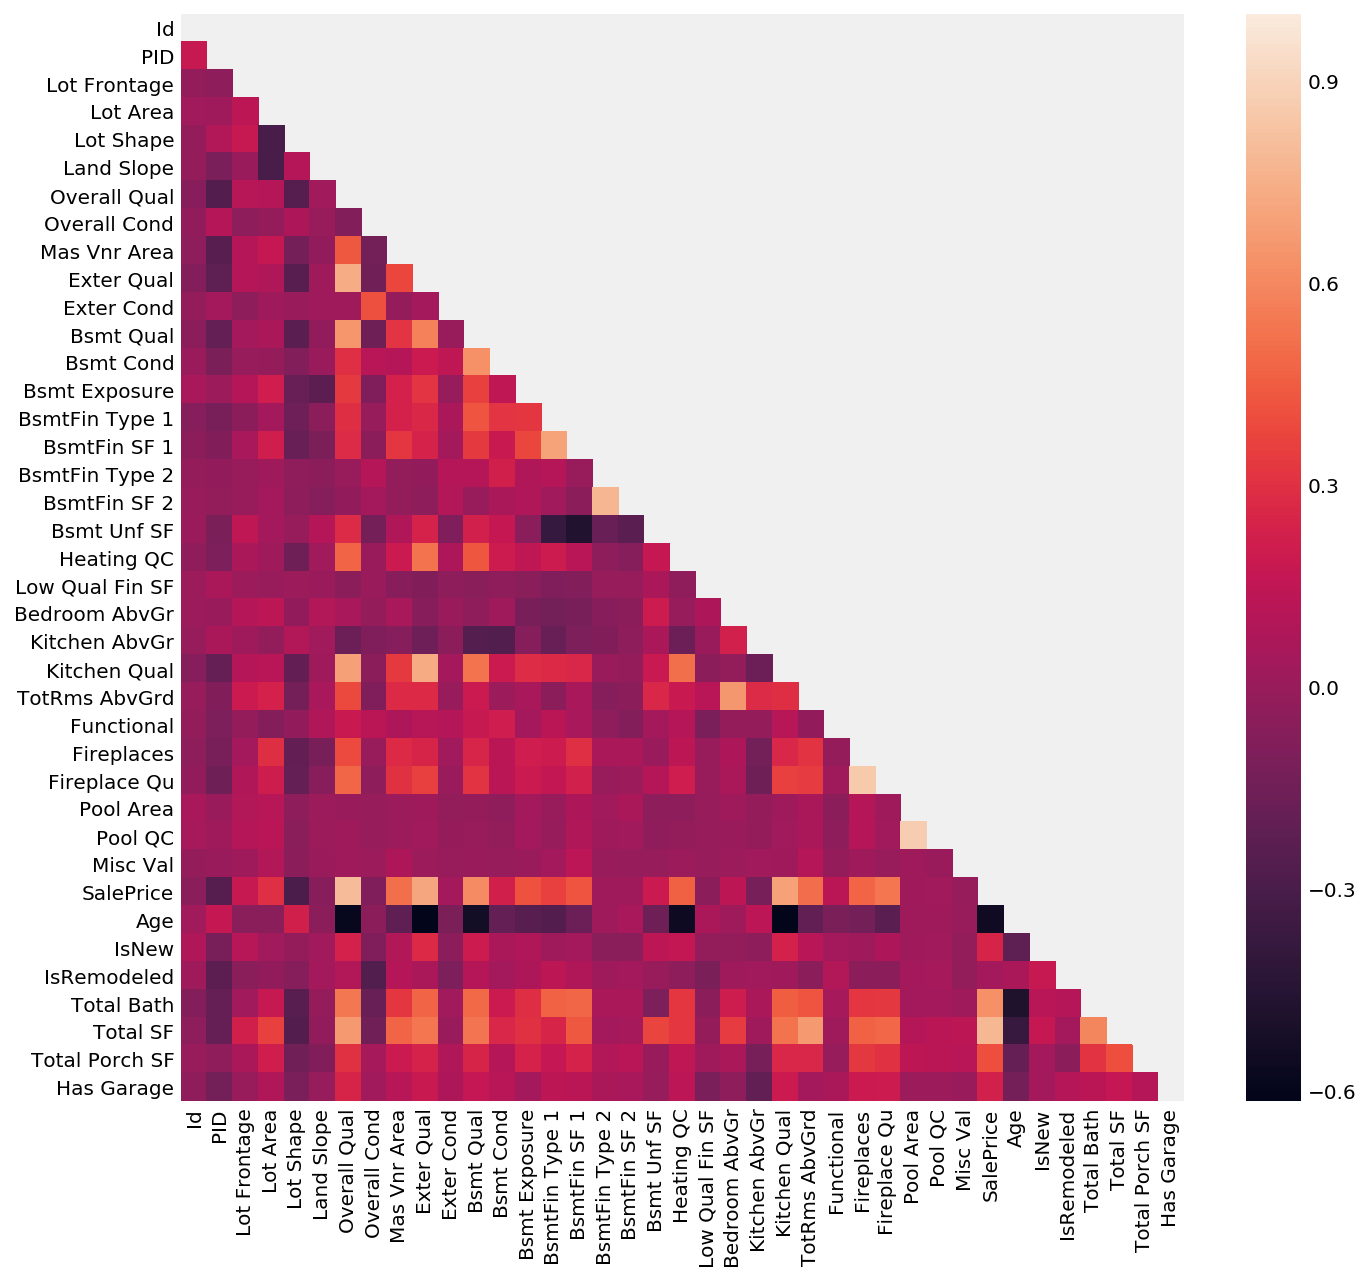

In [45]:
# Heatmap to better visualize the above correlations 
fig = plt.figure(figsize = (10,10))
ax = plt.gca()

# Generate a mask for the upper triangle 
mask = np.zeros_like(ames.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

# Plot heatmap (only lower triangle to remove duplicates)
sns.heatmap(ames.corr(), mask = mask, ax = ax);

In [46]:
# SalesPrice vs numeric columns pearson's correlation in descending order 
core = ames.corr() 
c1 = core.abs().unstack()
c1_sort = c1[:, 'SalePrice'].sort_values(ascending = False).head(10)        
c1_sort.head(10)

SalePrice       1.000000
Overall Qual    0.799201
Total SF        0.783945
Exter Qual      0.711050
Kitchen Qual    0.691436
Total Bath      0.630431
Bsmt Qual       0.610049
Age             0.551117
Fireplace Qu    0.537931
Mas Vnr Area    0.512182
dtype: float64

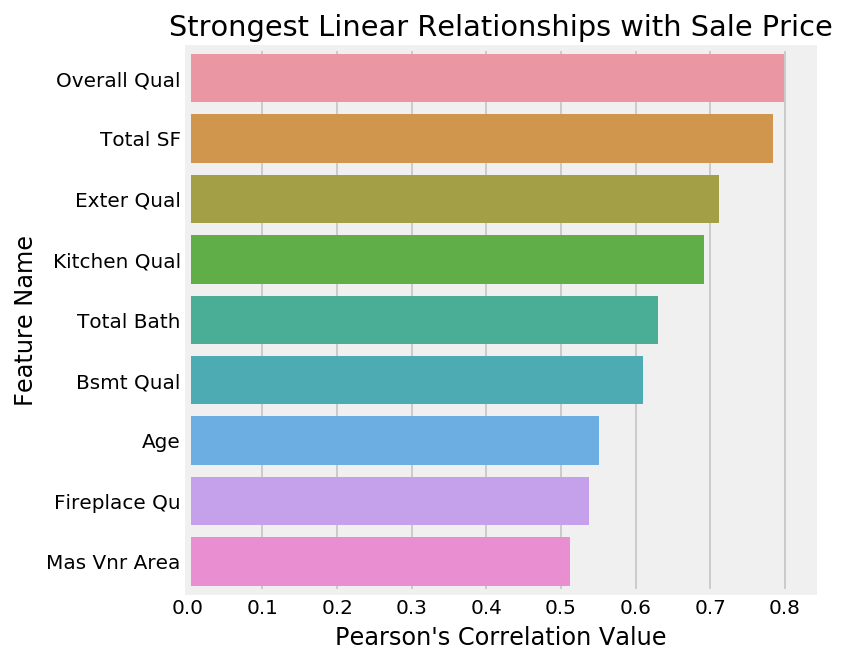

In [47]:
# Bar plot of Pearson's correlation values for salesprice determined above 
c1_sort.drop('SalePrice', inplace = True)
fig = plt.figure(figsize = (5,5))
sns.barplot(x= c1_sort.head(10), y=c1_sort.head(10).index, orient = 'h')
plt.xlabel("Pearson's Correlation Value")
plt.ylabel("Feature Name")
plt.title("Strongest Linear Relationships with Sale Price");

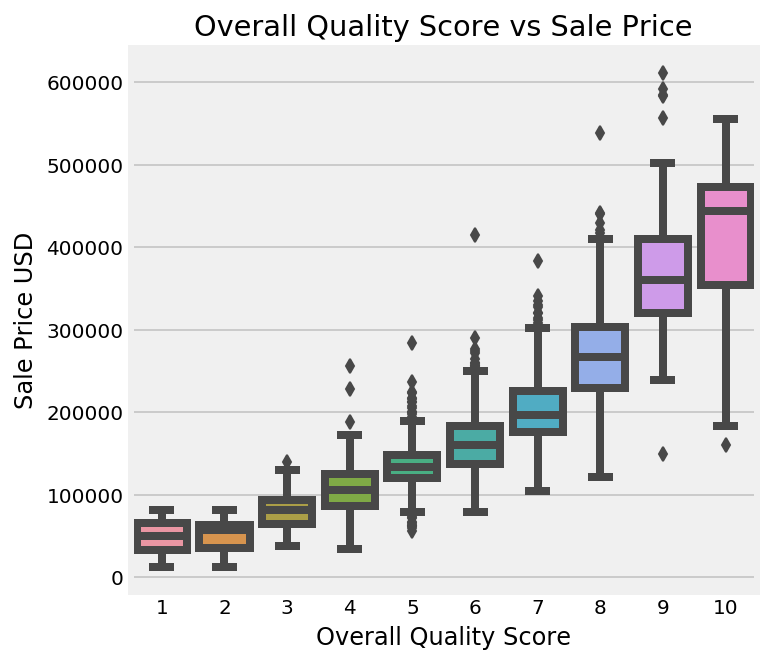

In [48]:
# Overall Quality has the highest linear correlation with saleprice
fig = plt.figure(figsize = (5,5))
sns.boxplot(x = ames['Overall Qual'], y = ames['SalePrice'])
plt.xlabel("Overall Quality Score")
plt.ylabel("Sale Price USD")
plt.title('Overall Quality Score vs Sale Price');

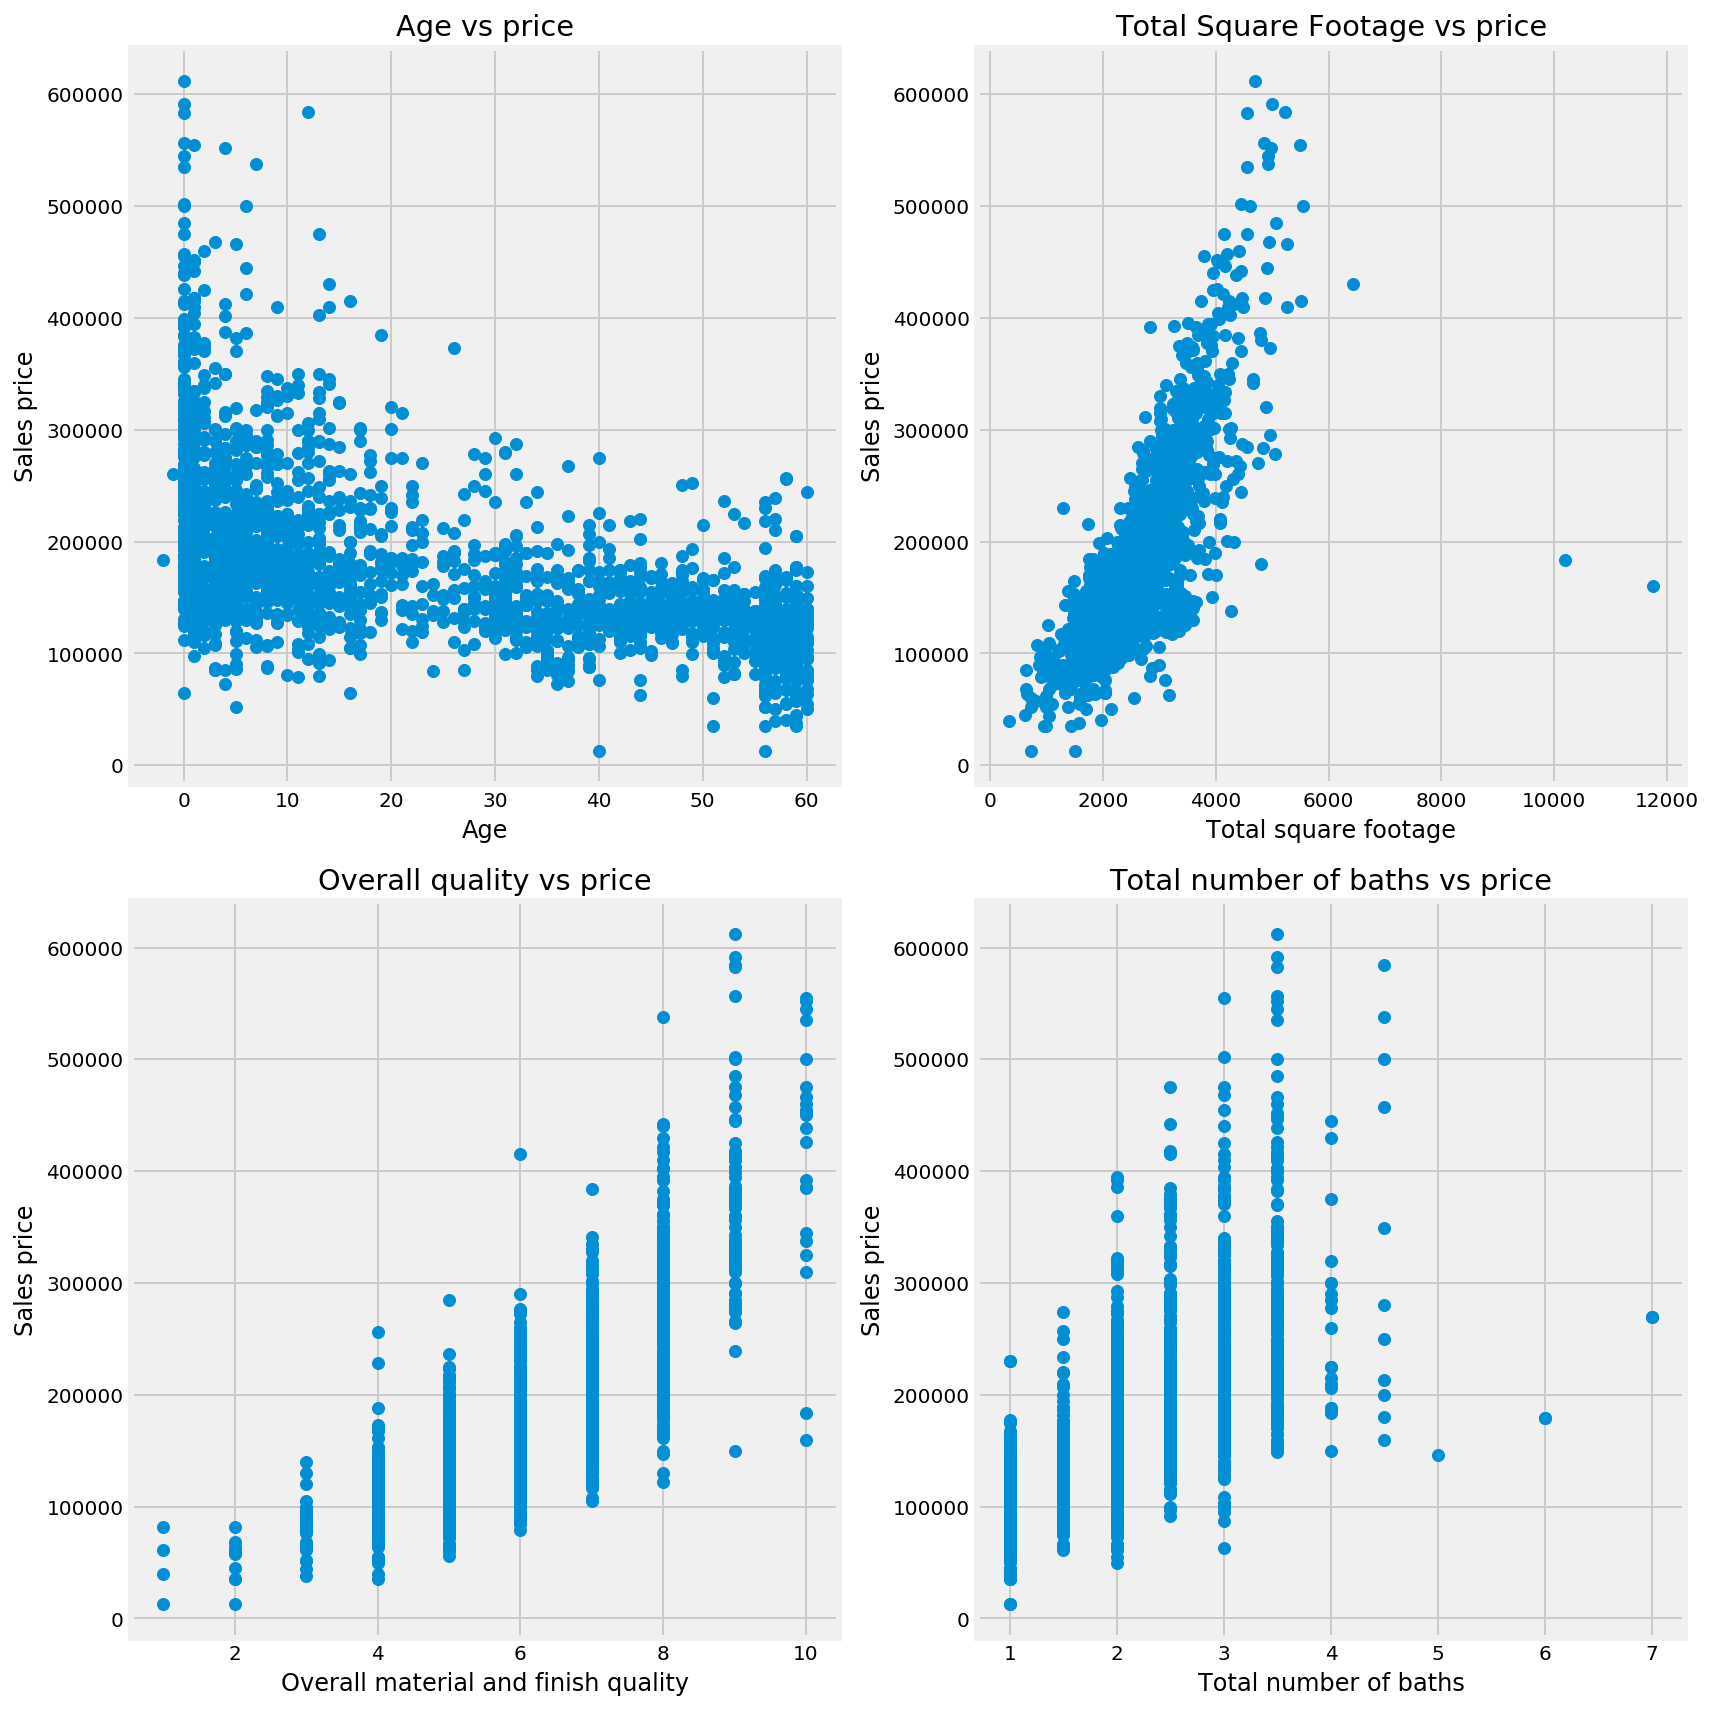

In [49]:
# Age, Total SF, Total Bath, and Overall Qual have strongest linear relationships with SalesPrice 
# Scatter plots to compare relationships with SalesPrice

# Initialize figure and axes
fig, ax = plt.subplots(2,2,figsize = (12,12))

# Plot
ax[0,0].scatter(ames['Age'], ames['SalePrice'])
ax[0,1].scatter(ames['Total SF'], ames['SalePrice'])
ax[1,0].scatter(ames['Overall Qual'], ames['SalePrice'])
ax[1,1].scatter(ames['Total Bath'], ames['SalePrice']);

# Add labels
ax[0,0].set_title('Age vs price');
ax[0,0].set_xlabel('Age');
ax[0,0].set_ylabel('Sales price');
ax[0,1].set_title('Total Square Footage vs price');
ax[0,1].set_xlabel('Total square footage');
ax[0,1].set_ylabel('Sales price');
ax[1,0].set_title('Overall quality vs price');
ax[1,0].set_xlabel('Overall material and finish quality');
ax[1,0].set_ylabel('Sales price');
ax[1,1].set_title('Total number of baths vs price');
ax[1,1].set_xlabel('Total number of baths');
ax[1,1].set_ylabel('Sales price');

fig.tight_layout()

There are obvious visual outliers in both the Total SF and Total Bath vs SalesPrice scatter plots above. These houses have a massive square footage but a very low price, which doesn't seem very likely, and are separated from the obvious clusters. I will identify these 2 outliers and then drop their rows from the dataframe. 

In [50]:
# Identify 2 outliers in Total SF
ames[ames['Total SF'] > 10000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Yr Sold,Sale Type,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
960,1499,908154235,2-STORY 1946 & NEWER,RL,313.0,63887,Pave,No,1,Bnk,...,2008,New,160000,0,1,1,4.5,11752.0,506,1
1885,2181,908154195,1-STORY 1946 & NEWER ALL STYLES,RL,128.0,39290,Pave,No,3,Bnk,...,2007,New,183850,-2,0,0,4.0,10190.0,1030,1


In [51]:
# Remove the 2 outliers found above 
ames.drop([960, 1885], inplace = True)

In [52]:
# Identify 3 outliers in Total Bath - it looks like they are counting all the baths from the entire duplex 
ames[ames['Total Bath'] >= 6]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Yr Sold,Sale Type,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
791,763,904301060,DUPLEX - ALL STYLES AND AGES,RL,60.0,10800,Pave,No,4,Lvl,...,2009,WD,179000,21,0,0,6.0,2400.0,120,0
1566,816,906230010,DUPLEX - ALL STYLES AND AGES,RL,0.0,11855,Pave,No,4,Lvl,...,2009,WD,269500,9,0,1,7.0,3955.0,312,1
1584,764,904301070,DUPLEX - ALL STYLES AND AGES,RL,60.0,10800,Pave,No,4,Lvl,...,2009,WD,179000,21,0,0,6.0,2400.0,120,0
1605,817,906230020,DUPLEX - ALL STYLES AND AGES,RL,0.0,7939,Pave,No,4,Lvl,...,2009,WD,269500,9,0,1,7.0,3955.0,312,1


In [53]:
# Drop the 4 outliers 
ames.drop([791, 1566, 1584, 1605], inplace = True)

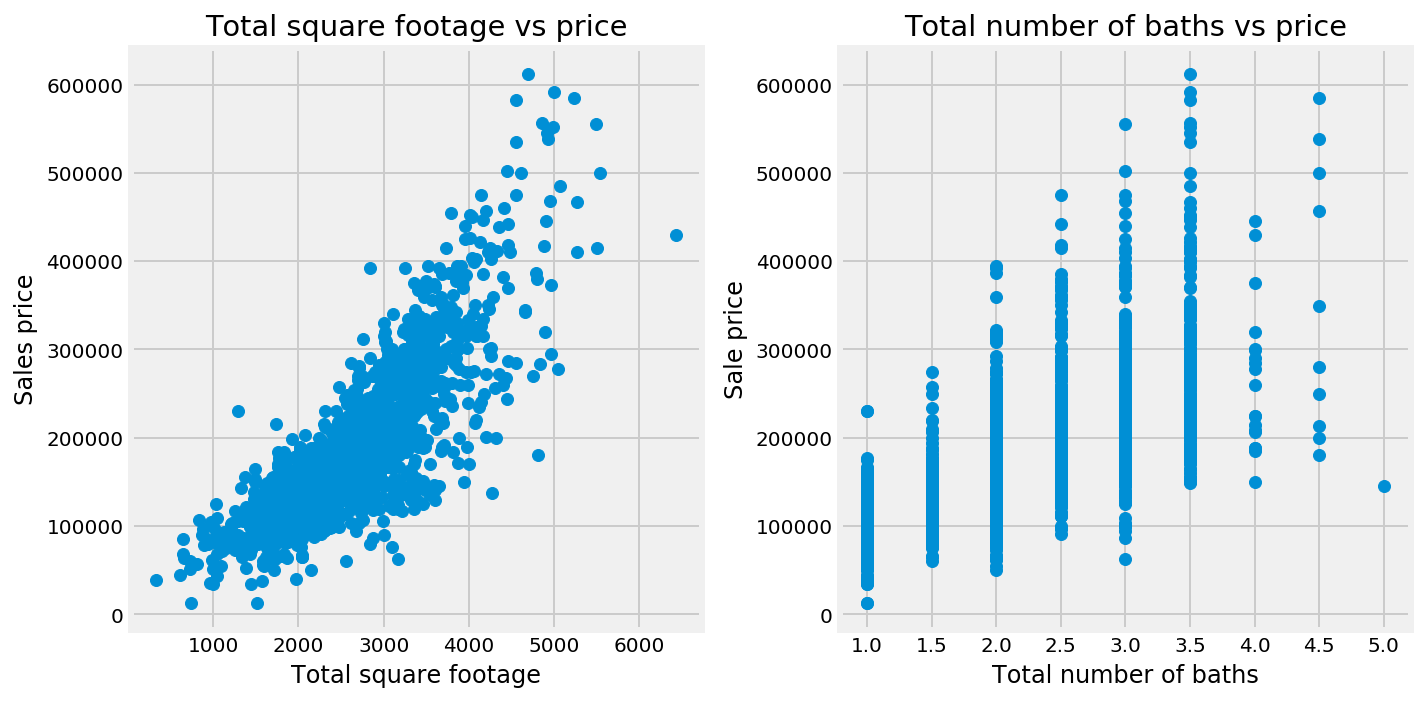

In [54]:
# Replot General Living and total basement area relationships to confirm 

# Initialize figure and axes
fig, ax = plt.subplots(1,2,figsize = (10,5))

# Plot
ax[0].scatter(ames['Total SF'], ames['SalePrice'])
ax[1].scatter(ames['Total Bath'], ames['SalePrice']);

# Add labels
ax[0].set_title('Total square footage vs price');
ax[0].set_xlabel('Total square footage');
ax[0].set_ylabel('Sales price');
ax[1].set_title('Total number of baths vs price');
ax[1].set_xlabel('Total number of baths');
ax[1].set_ylabel('Sale price');

fig.tight_layout()

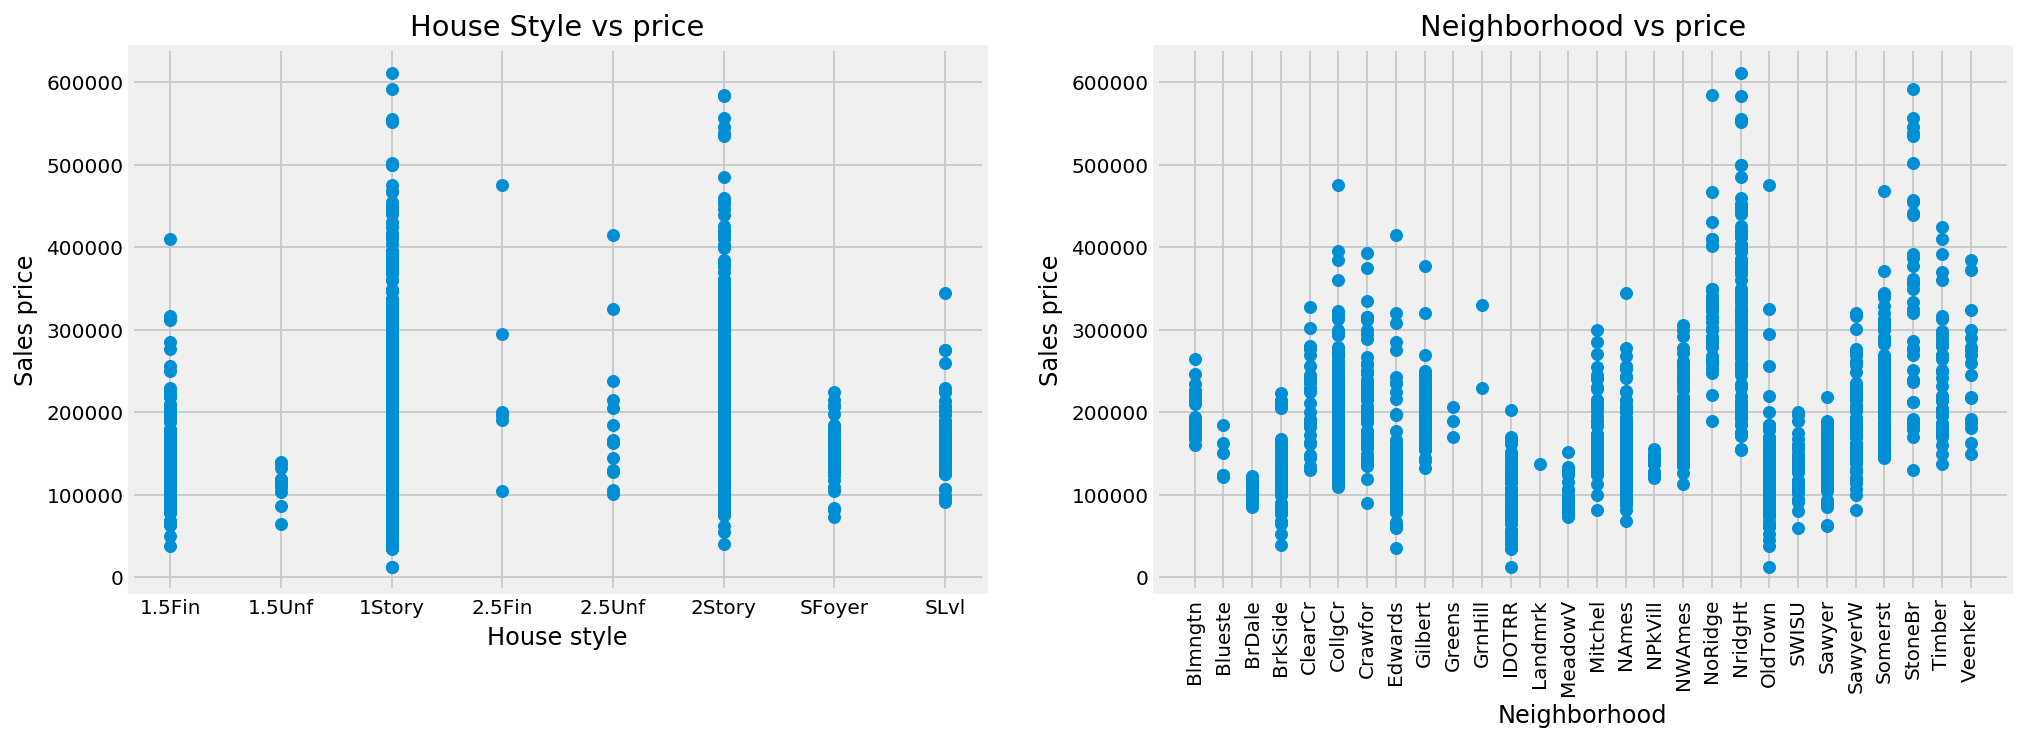

In [55]:
# Investigate neighborhood, house style
fig, ax = plt.subplots(1,2,figsize = (15,5))

# Plot
ax[0].scatter(ames['House Style'], ames['SalePrice'])
ax[1].scatter(ames['Neighborhood'], ames['SalePrice']);
plt.xticks(rotation=90);

# Add labels
ax[0].set_title('House Style vs price');
ax[0].set_xlabel('House style');
ax[0].set_ylabel('Sales price');
ax[1].set_title('Neighborhood vs price');
ax[1].set_xlabel('Neighborhood');
ax[1].set_ylabel('Sales price');

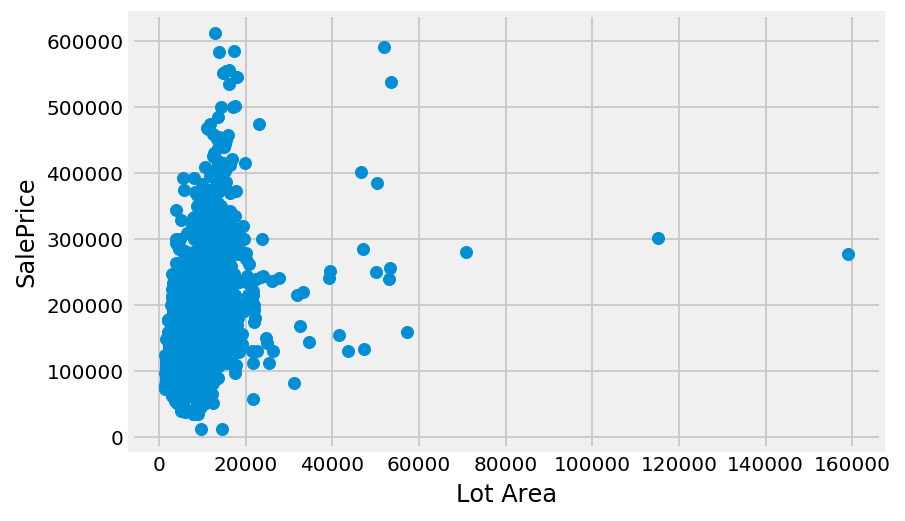

In [56]:
# Plot Lot Area
fig = plt.figure()
plt.scatter(ames['Lot Area'], ames['SalePrice'])
plt.xlabel('Lot Area')
plt.ylabel('SalePrice');

In [57]:
# Identify Lot Area outliers 
ames[ames['Lot Area'] >= 100000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Yr Sold,Sale Type,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
471,2116,906426060,1-1/2 STORY FINISHED ALL AGES,RL,0.0,159000,Pave,No,2,Low,...,2007,WD,277000,1,0,0,2.5,3588.0,98,1
694,2072,905301050,1-STORY 1946 & NEWER ALL STYLES,RL,0.0,115149,Pave,No,2,Low,...,2007,WD,302000,5,0,0,3.0,3467.0,428,1


In [58]:
# Drop 2 outliers above 
ames.drop([471, 694], inplace = True)

From the correlation matrix and EDA, it is apparent that there is a high degree of multicollinearity in the predictor variables. In order to remove some of the multicollinearity, I will drop columns that convey the same information (for example Garage Cars vs Garage Area) and take the column that has the highest correlation to SalePrice. 

In [59]:
# Identify highly correlated variables 
core = ames.corr() 
c1 = core.abs().unstack()
c1.sort_values(ascending = False).head(60)   

Has Garage       Has Garage         1.000000
Bsmt Unf SF      Bsmt Unf SF        1.000000
Bedroom AbvGr    Bedroom AbvGr      1.000000
Kitchen AbvGr    Kitchen AbvGr      1.000000
Kitchen Qual     Kitchen Qual       1.000000
TotRms AbvGrd    TotRms AbvGrd      1.000000
Functional       Functional         1.000000
Fireplaces       Fireplaces         1.000000
Fireplace Qu     Fireplace Qu       1.000000
Pool Area        Pool Area          1.000000
Pool QC          Pool QC            1.000000
Misc Val         Misc Val           1.000000
SalePrice        SalePrice          1.000000
Age              Age                1.000000
IsNew            IsNew              1.000000
IsRemodeled      IsRemodeled        1.000000
Total Bath       Total Bath         1.000000
Low Qual Fin SF  Low Qual Fin SF    1.000000
BsmtFin SF 2     BsmtFin SF 2       1.000000
Total Porch SF   Total Porch SF     1.000000
BsmtFin Type 2   BsmtFin Type 2     1.000000
PID              PID                1.000000
Lot Fronta

In [60]:
# Drop highly correlated variables - keep the one that is more correlated to SalePrice
ames.drop(['Fireplaces', 'Pool Area', 'Exter Qual', 'Kitchen Qual', 
           'BsmtFin Type 2', 'BsmtFin Type 1'], axis = 1, inplace = True)
test.drop(['Fireplaces', 'Pool Area', 'Exter Qual', 'Kitchen Qual',
           'BsmtFin Type 2', 'BsmtFin Type 1' ], axis = 1, inplace = True)

In [61]:
ames.describe()

,Id,PID,Lot Frontage,Lot Area,Lot Shape,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Cond,...,Pool QC,Misc Val,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
count,2020.000000,2.020000e+03,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,...,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,1473.257921,7.139822e+08,57.936139,9887.169307,3.599505,2.948515,6.095545,5.569802,98.709901,3.086634,...,0.009406,43.702475,180720.335644,23.871782,0.036634,0.536634,2.203960,2537.179703,182.322772,0.945545
std,845.950453,1.886949e+08,32.510316,5240.453887,0.561696,0.238293,1.421995,1.109006,172.513284,0.374945,...,0.161747,437.442605,79171.026984,21.033474,0.187907,0.498780,0.781779,765.586962,159.253595,0.226970
min,1.000000,5.263011e+08,0.000000,1300.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,12789.000000,-1.000000,0.000000,0.000000,1.000000,334.000000,0.000000,0.000000
25%,748.750000,5.284770e+08,44.000000,7500.000000,3.000000,3.000000,5.000000,5.000000,0.000000,3.000000,...,0.000000,0.000000,129500.000000,4.000000,0.000000,0.000000,1.500000,2004.000000,48.000000,1.000000
50%,1480.500000,5.354540e+08,63.000000,9395.500000,4.000000,3.000000,6.000000,5.000000,0.000000,3.000000,...,0.000000,0.000000,161000.000000,16.000000,0.000000,1.000000,2.000000,2452.000000,164.000000,1.000000
75%,2199.250000,9.071801e+08,78.000000,11478.250000,4.000000,3.000000,7.000000,6.000000,160.000000,3.000000,...,0.000000,0.000000,213062.500000,44.000000,0.000000,1.000000,2.500000,2988.250000,267.000000,1.000000
max,2930.000000,9.241520e+08,313.000000,70761.000000,4.000000,3.000000,10.000000,9.000000,1600.000000,5.000000,...,4.000000,12500.000000,611657.000000,60.000000,1.000000,1.000000,5.000000,6428.000000,1424.000000,1.000000


In [62]:
# Check for negative Age 
ames[ames['Age'] < 0]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Yr Sold,Sale Type,SalePrice,Age,IsNew,IsRemodeled,Total Bath,Total SF,Total Porch SF,Has Garage
1719,1703,528120010,2-STORY 1946 & NEWER,RL,134.0,16659,Pave,No,3,Lvl,...,2007,New,260116,-1,1,0,2.5,3734.0,368,1


In [63]:
# Drop negative Age as outlier - must have had incorrect entry process 
ames.drop([1719], inplace = True)

### Step 5: Modeling

Before I get into modeling, I want to account for the skewness in the data. As I saw in EDA, SalePrice is right skewed and I suspect that many other variables are also skewed. For a normal distribution, we typically want skew values between -1 and 1. I will take the log of all variables that have a skew lower than -0.7 or higher than 0.7 

In [64]:
# Skew test on all numeric variables 
skewed = abs(ames.skew())
skewed.sort_values(ascending = False).head(25)

Pool QC            18.917781
Misc Val           18.452512
Low Qual Fin SF    11.409432
Functional          5.296601
IsNew               4.973107
Land Slope          4.909093
Kitchen AbvGr       4.390460
BsmtFin SF 2        4.210800
Lot Area            3.972013
Has Garage          3.928753
Bsmt Cond           3.486746
Mas Vnr Area        2.559539
SalePrice           1.578469
Total Porch SF      1.364187
Bsmt Qual           1.281031
Bsmt Exposure       1.240736
Exter Cond          1.221361
Lot Shape           1.170797
Bsmt Unf SF         0.914765
BsmtFin SF 1        0.820503
TotRms AbvGrd       0.785019
Total SF            0.690338
Overall Cond        0.625409
Heating QC          0.563818
Age                 0.430014
dtype: float64

In [65]:
# Take the log of the columns wit skew > 0.7, ignore IsNew, Has Pool, Has Porch since these are dummy variables
skew_col = ['Misc Val', 'Pool QC', 'Total Porch SF' ,'Lot Area', 'Functional','Kitchen AbvGr', 'BsmtFin SF 2',
            'Land Slope', 'Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure', 'Exter Cond','Lot Shape', 'Exter Cond',
            'Mas Vnr Area', 'SalePrice', 'TotRms AbvGrd', 'Total SF', 'Low Qual Fin SF', 'Bsmt Unf SF', 'BsmtFin SF 1'] 

for col in skew_col:
    ames[col] = np.log1p(ames[col])
    
# Remove SalePrice from skew_col since the test data doesn't have it 
skew_col.pop(15)

for col in skew_col:
    test[col] = np.log1p(test[col])

In [66]:
# Convert all categorical models to numerics so that we can model them in both train and test data
ames = pd.get_dummies(ames, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [67]:
# Define features and target in train data
X = ames.drop(['SalePrice'], axis = 1)
y = ames['SalePrice']

In [68]:
# Define features in test data
X_test = test

We also need to make sure that the train and test data have the same columns. It is possible that there are categorical values in test that are not present in the train. We also don't want to use the new values in the test in our model, since our model should not be able to account for it. In the below I account for these potential differences.  

In [69]:
# Get missing columns in the training set
missing_cols = set(X.columns ) - set(X_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X.columns]

In [70]:
# Standardize the predictors in train and test data
ss = StandardScaler()
ss.fit(X) 
X_scaled = ss.transform(X)
X_scaled_test = ss.transform(X_test)

In [71]:
# Train/test split on training data to help optimize model before exposing to Kaggle test dataset 
X_train, X_test_primary, y_train, y_test_primary = train_test_split(X_scaled, y, test_size = 0.1, train_size = 0.9)

Now that the data has been split and standardized, I will see which model gives the best baseline unfitted cross validation score to inform model optimization. 

In [72]:
# Create RMSE cross validation function 
def rmse(model, X, y):
    cv_mean_mse = -cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
    return np.sqrt(cv_mean_mse)

In [73]:
# Cross validation on unfitted simple Linear Regression - output RSME
lr = LinearRegression()
rmse(lr, X_train, y_train)

104258310912.98013

In [74]:
# Cross validation on Ridge  - output RSME 
ridge_model = RidgeCV(cv = 5)
rmse(ridge_model, X_train, y_train)

0.1292672688586786

In [75]:
# Cross validation on Lasso  - output RSME 
lasso_model = LassoCV(n_alphas = 200, cv = 5)
rmse(lasso_model, X_train, y_train)

0.12642983012831874

In [76]:
# Cross validation on Elastic Net  - output RSME 
elastic_model = ElasticNetCV(n_alphas = 200, l1_ratio = 0.8, cv = 5)
rmse(elastic_model, X_train, y_train)

0.1264274215415582

When we compare the cross validation RSME on the unfitted models, we get an approximation/baseline for how each model will perform. Lasso had the lowest RSME, indicating it might have the best potential. I will try both lasso and elastic net since they are fairly close. 

In [77]:
# Initialize and fit lasso model 
lasso_model = LassoCV(n_alphas = 300, cv = 5)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [78]:
# Calculate the RMSE on the fit training data 
predictions = lasso_model.predict(X_train)
metrics.mean_squared_error(np.expm1(y_train), np.expm1(predictions)) ** 0.5

20734.460406841026

In [79]:
# Calculate the RMSE on the test training data 
predictions = lasso_model.predict(X_test_primary)
metrics.mean_squared_error(np.expm1(y_test_primary), np.expm1(predictions)) ** 0.5

19093.305599836352

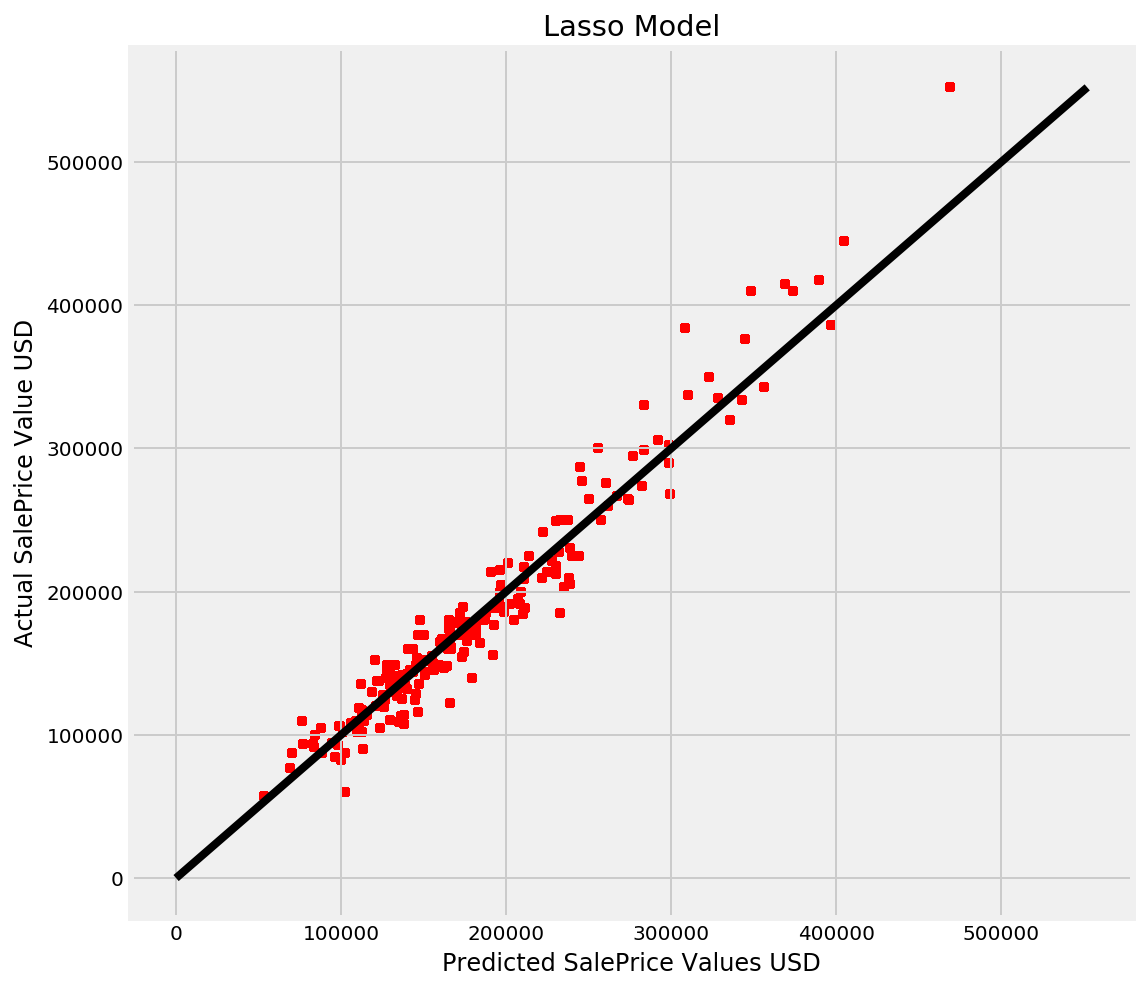

In [80]:
# Plot lasso model test predictions vs true data 
plt.figure(figsize=(8,8))
plt.scatter(np.expm1(predictions), np.expm1(y_test_primary), s=30, c='r', marker='+', zorder=0)
plt.xlabel("Predicted SalePrice Values USD")
plt.ylabel("Actual SalePrice Value USD")
plt.title("Lasso Model")

plt.plot([0, np.max(np.expm1(y_test_primary))], [0, np.max(np.expm1(y_test_primary))], c = 'k')

plt.show()

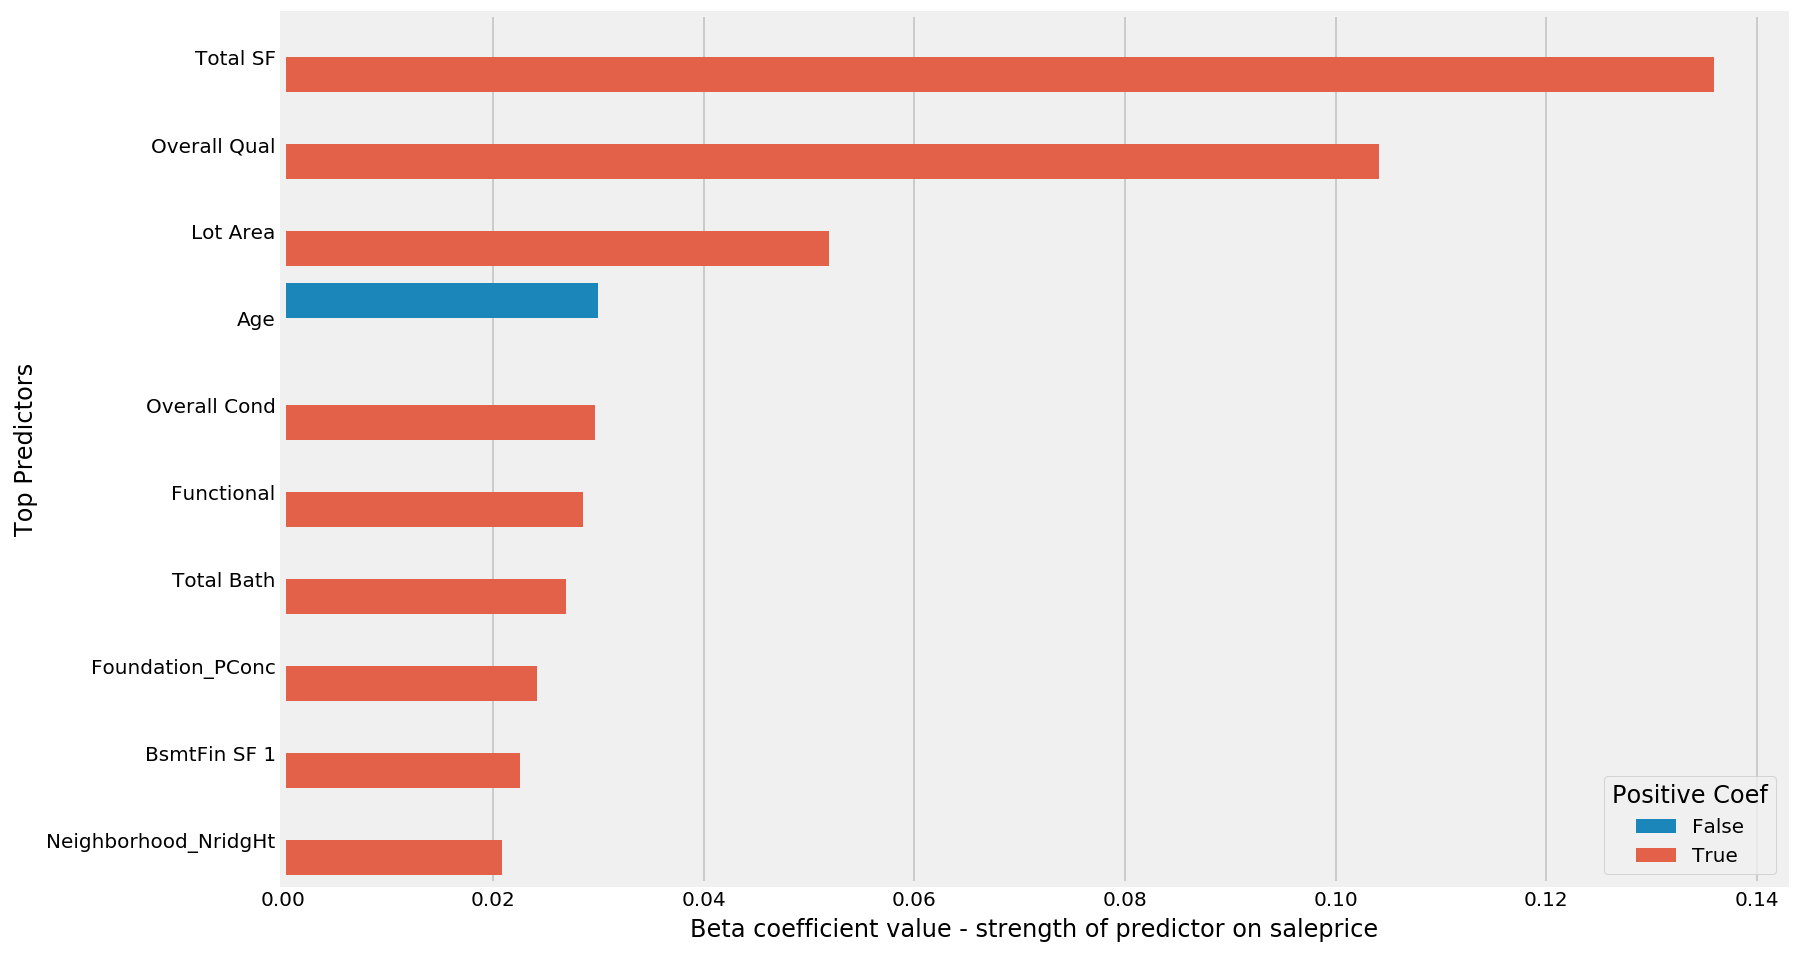

In [81]:
# Plot the top predictors (highest absolute value lasso coefficients)
coefs = pd.DataFrame(lasso_model.coef_, index = X.columns, columns = ['coef'])
coefs['Positive Coef'] = coefs.coef > 0
coefs['abs'] = np.abs(coefs.coef)
coefs.sort_values(by='abs', ascending = False, inplace=True)

plt.figure(figsize = (12,8))
sns.barplot(y=coefs.head(10).index, x=coefs.head(10)['abs'], hue = coefs.head(10)['Positive Coef'], orient = 'h');
plt.xlabel('Beta coefficient value - strength of predictor on saleprice')
plt.ylabel('Top Predictors');

In [82]:
# Number of features the model is using 
coefs[coefs['abs'] != 0].shape[0]

99

#### Alternative Model 

Since Lasso and Elastic Net CV baseline RMSE scores were similar, I am going to create an Elastic Net model and see how it compares to the Lasso Model above. 

In [83]:
# Initialize and fit elastic net model 
elastic_model = ElasticNetCV(l1_ratio = 0.9, n_alphas = 300, cv = 5)
elastic_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.9, max_iter=1000, n_alphas=300, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [84]:
# Calculate the RMSE on the fit training data 
predictions2 = elastic_model.predict(X_train)
metrics.mean_squared_error(np.expm1(y_train), np.expm1(predictions2)) ** 0.5

20737.169878007433

In [85]:
# Calculate the RMSE on the test training data 
predictions2 = elastic_model.predict(X_test_primary)
metrics.mean_squared_error(np.expm1(y_test_primary), np.expm1(predictions2)) ** 0.5

19095.678050768012

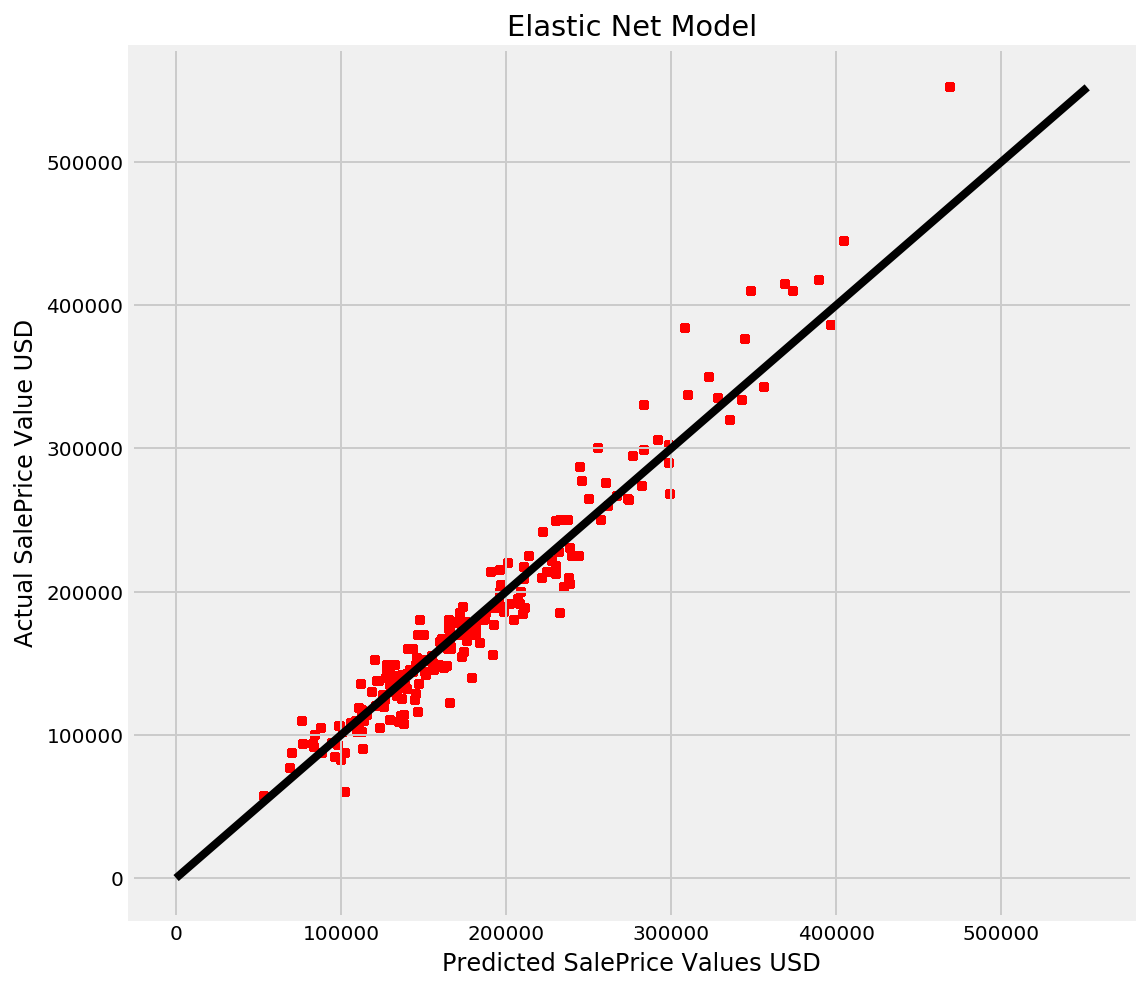

In [86]:
# Plot elastic net model test predictions vs true data 
plt.figure(figsize=(8,8))
plt.scatter(np.expm1(predictions2), np.expm1(y_test_primary), s=30, c='r', marker='+', zorder=0)
plt.xlabel("Predicted SalePrice Values USD")
plt.ylabel("Actual SalePrice Value USD")
plt.title("Elastic Net Model")

plt.plot([0, np.max(np.expm1(y_test_primary))], [0, np.max(np.expm1(y_test_primary))], c = 'k')

plt.show()

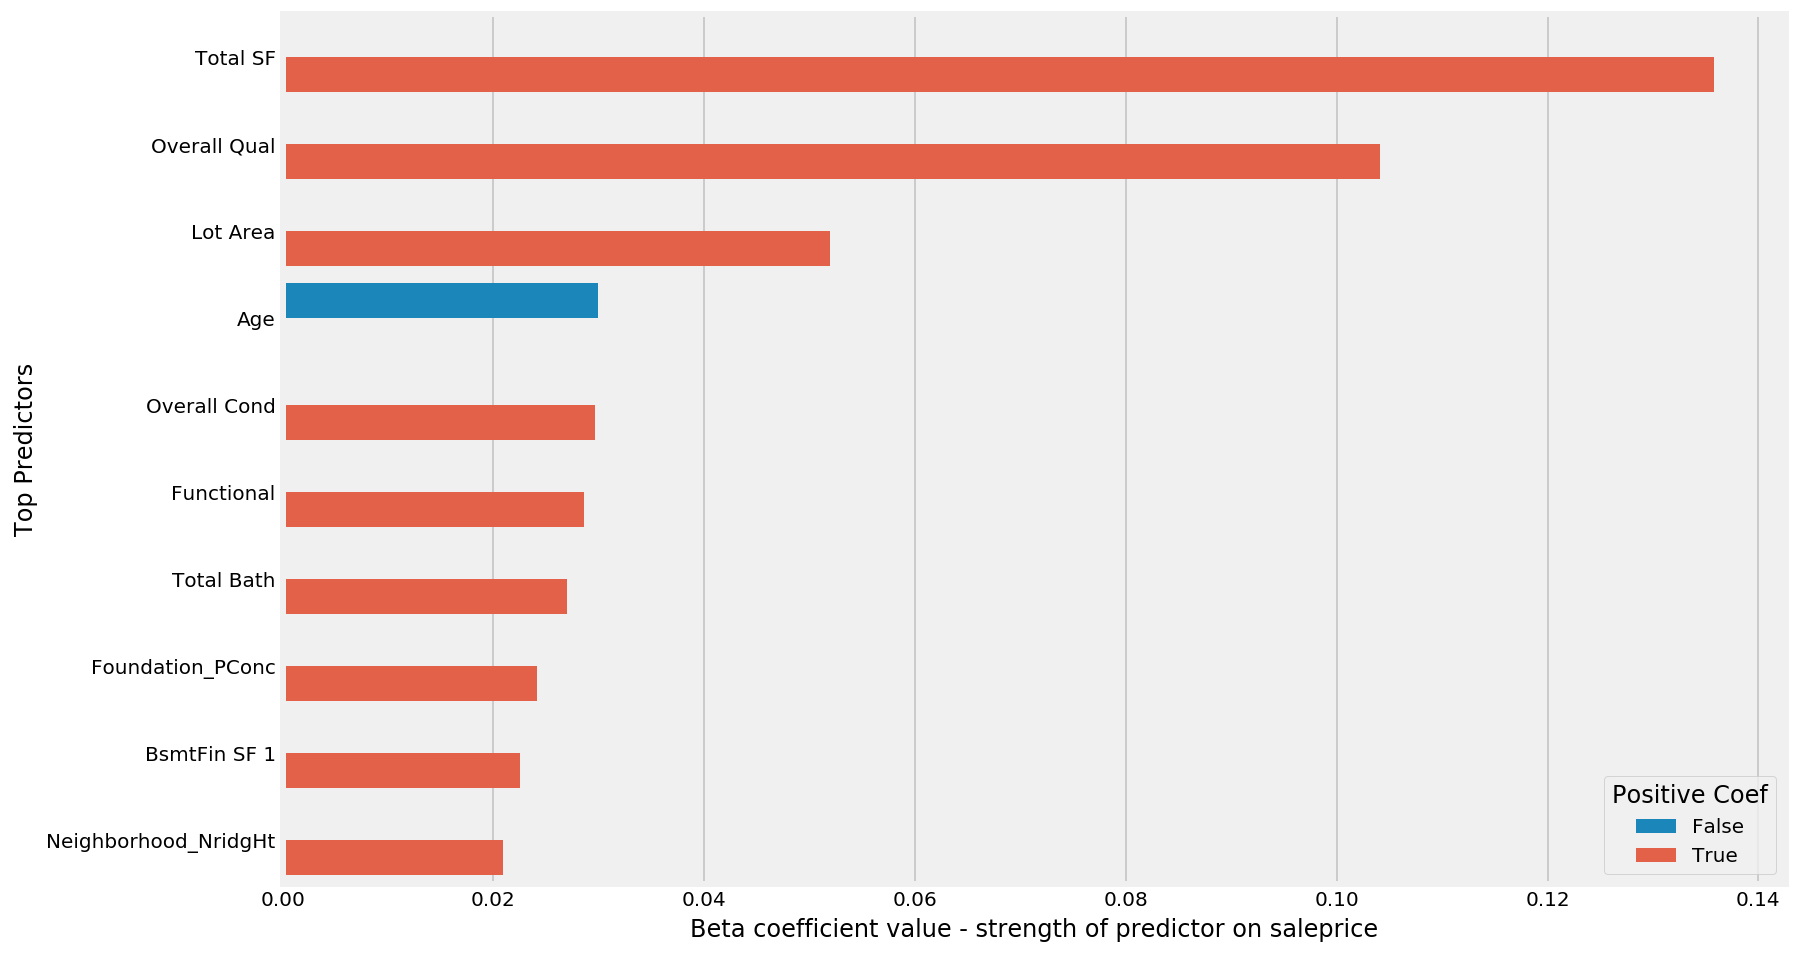

In [87]:
# Plot the top predictors (highest absolute value lasso coefficients)
coefs = pd.DataFrame(elastic_model.coef_, index = X.columns, columns = ['coef'])
coefs['Positive Coef'] = coefs.coef > 0
coefs['abs'] = np.abs(coefs.coef)
coefs.sort_values(by='abs', ascending = False, inplace=True)

plt.figure(figsize = (12,8))
sns.barplot(y=coefs.head(10).index, x=coefs.head(10)['abs'], hue = coefs.head(10)['Positive Coef'], orient = 'h');
plt.xlabel('Beta coefficient value - strength of predictor on saleprice')
plt.ylabel('Top Predictors');

In [88]:
# Number of features the model uses 
coefs[coefs['abs'] != 0].shape[0]

99

The Lasso model had a slightly slower RMSE than the Elastic Net model (l1_ratio = 0.9). The top 10 indicators remained the same for both models.  

### Step 6: Test Final Model with Kaggle test data

In [89]:
# Make predictions based on test data for both models 
predictions = lasso_model.predict(X_scaled_test)
predictions2 = elastic_model.predict(X_scaled_test)

In [90]:
# Need to convert Y back into non log 
predictions = np.expm1(predictions)
predictions2 = np.expm1(predictions2)

In [91]:
# Format predictions for the Kaggle submission 
results = X_test.copy(deep = True)
results["SalePrice"] = predictions
results[["Id", "SalePrice"]].to_csv("Results.csv", index=False)

# Elastic net predictions 
results2 = X_test.copy(deep = True)
results2['SalePrice'] = predictions2
results2[['Id', 'SalePrice']].to_csv('Results_alt.csv', index = False)

In [92]:
# Confirm final submission has 879 rows 
results.shape, results2.shape

((879, 206), (879, 206))